<a href="https://colab.research.google.com/github/valerian-drmt/Finance/blob/main/Projects/LSTM_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import vectorbt as vbt
import time
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

| Interval       | Max Lookback Period (approx)  |
|----------------|-------------------------------|
| `'1m'`         | 7 days                        |
| `'2m'`         | 60 days                       |
| `'5m'`         | 60 days                       |
| `'15m'`        | 60 days                       |
| `'30m'`        | 60 days                       |
| `'60m'` / `'1h'` | 730 days (~2 years)        |
| `'1d'`         | ~20+ years                    |
| `'1wk'`        | ~20+ years                    |
| `'1mo'`        | ~20+ years                    |

In [15]:
#data_request = vbt.BinanceData.download("BTCUSDT", start="2025-04-14", end="2025-04-17", interval="1m")
data_request = vbt.YFData.download("BTC-USD", start="2025-04-14", end="2025-04-17", interval="1m")
data = data_request.get()
print(data.head())
print(data["Volume"].iloc[-1])
time.sleep(3)

data_request = data_request.update()
data = data_request.get()
print(data["Volume"].iloc[-1])


                                   Open          High           Low  \
Datetime                                                              
2025-04-14 00:00:00+00:00  83714.000000  83714.000000  83714.000000   
2025-04-14 00:01:00+00:00  83706.945312  83706.945312  83706.945312   
2025-04-14 00:02:00+00:00  83741.062500  83741.062500  83741.062500   
2025-04-14 00:03:00+00:00  83729.085938  83729.085938  83729.085938   
2025-04-14 00:04:00+00:00  83800.125000  83800.125000  83800.125000   

                                  Close     Volume  Dividends  Stock Splits  
Datetime                                                                     
2025-04-14 00:00:00+00:00  83714.000000          0        0.0           0.0  
2025-04-14 00:01:00+00:00  83706.945312          0        0.0           0.0  
2025-04-14 00:02:00+00:00  83741.062500   38641664        0.0           0.0  
2025-04-14 00:03:00+00:00  83729.085938   94318592        0.0           0.0  
2025-04-14 00:04:00+00:00  83800.1

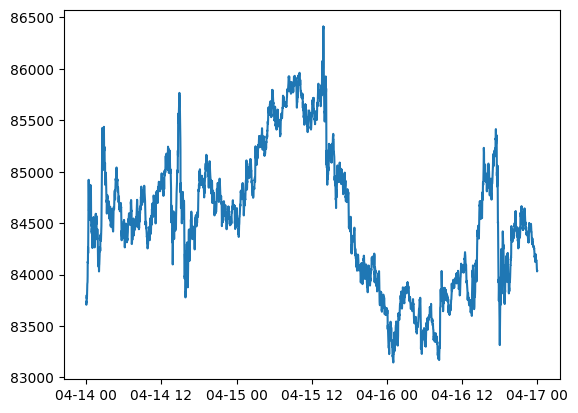

In [16]:
data.vbt.ohlcv.plot(plot_type="candlestick",show_volume=True)
plt.plot(data.index,data["Close"])

input = pd.DataFrame(index = data.index, data = {"Close":data["Close"]})
input = (input-input.min())/(input.max()-input.min())

In [23]:
def split_data(input, lookback, size_test_prct):
    data_raw = np.array(input) # convert to numpy array
    data = []
    lookback+=1 # +1 for output variable

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)

    test_set_size = int(np.round(size_test_prct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train, y_train, x_test, y_test]

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
lookback = 20 # choose sequence length
size_test_prct = 0.3
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

Epoch 1 / RMSE: 0.36278 / MAE: 0.31873 / R²: -2.67323 / MAPE: 667467.56%
Epoch 10 / RMSE: 0.18195 / MAE: 0.14264 / R²: 0.07603 / MAPE: 1504586.38%
Epoch 20 / RMSE: 0.14477 / MAE: 0.11361 / R²: 0.41504 / MAPE: 1257400.25%
Epoch 30 / RMSE: 0.05257 / MAE: 0.04332 / R²: 0.92288 / MAPE: 497296.78%
Epoch 40 / RMSE: 0.04116 / MAE: 0.03100 / R²: 0.95271 / MAPE: 11227.20%
Epoch 50 / RMSE: 0.03607 / MAE: 0.02684 / R²: 0.96369 / MAPE: 310025.41%
Epoch 60 / RMSE: 0.03219 / MAE: 0.02292 / R²: 0.97108 / MAPE: 236399.25%
Epoch 70 / RMSE: 0.03019 / MAE: 0.02160 / R²: 0.97457 / MAPE: 187610.30%
Epoch 80 / RMSE: 0.02906 / MAE: 0.02065 / R²: 0.97643 / MAPE: 174525.39%
Epoch 90 / RMSE: 0.02825 / MAE: 0.01994 / R²: 0.97773 / MAPE: 121692.30%
Epoch 100 / RMSE: 0.02750 / MAE: 0.01939 / R²: 0.97889 / MAPE: 128361.81%
Training time: 53.378029108047485


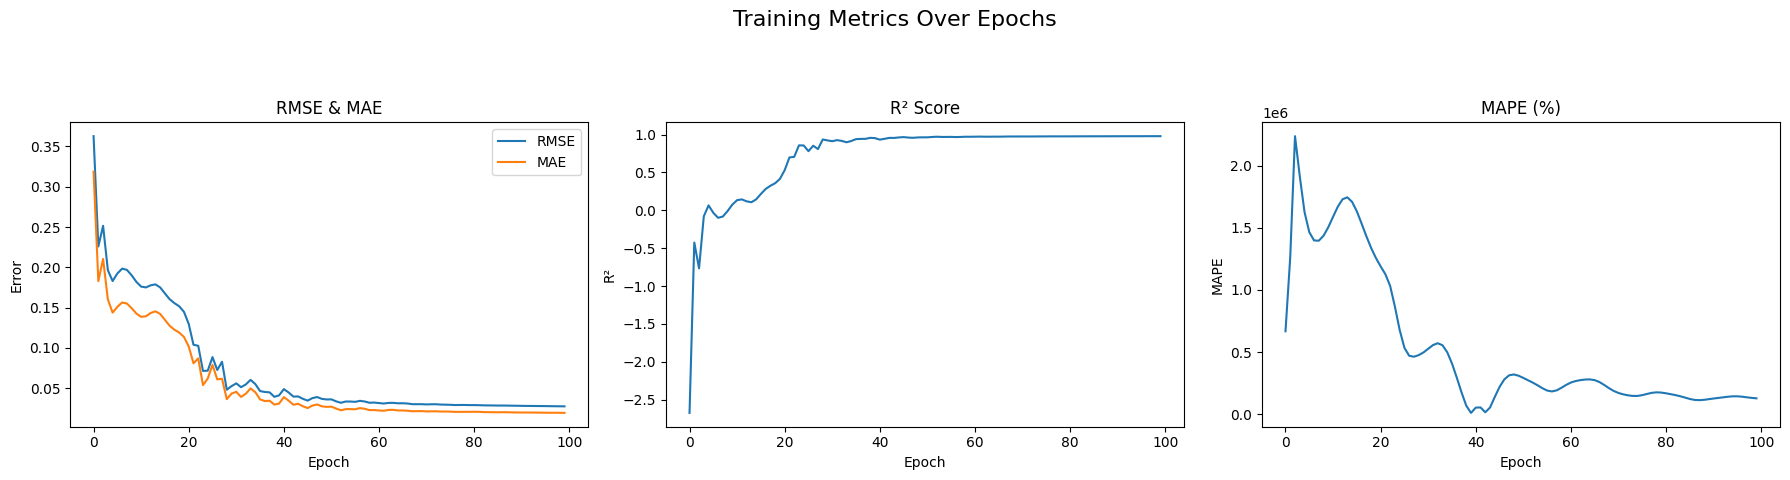

In [27]:
#Supprimer le train précédent
for var in ['model', 'optimiser', 'hist_rmse', 'hist_mae', 'hist_r2', 'hist_mape', 'MSE', 'MAE']:
    if var in locals():
        del globals()[var]
#-------------------------------------------------------------------------------
x_train, y_train, x_test, y_test = split_data(input, lookback, size_test_prct)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss functions
MSE = torch.nn.MSELoss(reduction='mean')
MAE = torch.nn.L1Loss(reduction='mean')

# Tracking
hist_rmse = np.zeros(num_epochs)
hist_mae = np.zeros(num_epochs)
hist_r2 = np.zeros(num_epochs)
hist_mape = np.zeros(num_epochs)

#-------------------------------------------------------------------------------
start_time = time.time()

for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train)

    # Compute losses
    mse_value = MSE(y_train_pred, y_train)
    rmse_value = torch.sqrt(mse_value)
    mae_value = MAE(y_train_pred, y_train)

    # Detach predictions for R2 and MAPE
    y_pred_np = y_train_pred.detach().cpu().numpy()
    y_true_np = y_train.detach().cpu().numpy()

    # R² Score
    r2_value = r2_score(y_true_np, y_pred_np)

    # MAPE (add small epsilon to avoid division by zero)
    epsilon = 1e-8
    mape_value = np.mean(np.abs((y_true_np - y_pred_np) / (y_true_np + epsilon))) * 100

    # Logging
    if (t+1)%10==0 or t==0:
      print(f"Epoch {t+1} / RMSE: {rmse_value.item():.5f} / MAE: {mae_value.item():.5f} / R²: {r2_value:.5f} / MAPE: {mape_value:.2f}%")

    hist_rmse[t] = rmse_value.item()
    hist_mae[t] = mae_value.item()
    hist_r2[t] = r2_value
    hist_mape[t] = mape_value

    # Backprop
    optimiser.zero_grad()
    mse_value.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

#-------------------------------------------------------------------------------
# Affichage des métriques
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training Metrics Over Epochs', fontsize=16)

# RMSE & MAE
axs[0].plot(hist_rmse, label="RMSE")
axs[0].plot(hist_mae, label="MAE")
axs[0].set(title="RMSE & MAE", xlabel="Epoch", ylabel="Error")
axs[0].legend()

# R²
axs[1].plot(hist_r2)
axs[1].set(title="R² Score", xlabel="Epoch", ylabel="R²")

# MAPE
axs[2].plot(hist_mape)
axs[2].set(title="MAPE (%)", xlabel="Epoch", ylabel="MAPE")

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

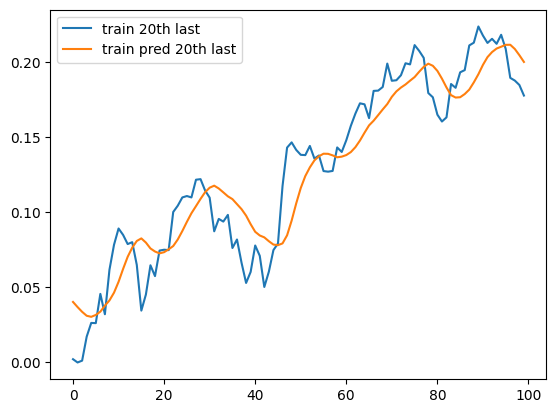

In [28]:
y_train = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
plt.plot(y_train[-lookback*5:], label=f"train {lookback}th last")
plt.plot(y_train_pred[-lookback*5:], label=f"train pred {lookback}th last")
plt.legend()
plt.show()